## Librerías y otras cosas útiles

In [1]:
import h5py
import torch
import pickle
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import linear_sum_assignment as linear_assignment
   
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

from utils import *

In [2]:
def heatmap(y_true, y_pred):
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    
    ind = linear_assignment(w.max() - w)
    w_order = np.zeros((D, D), dtype=np.int64)
    for i in range(D):
        for j in range(D):
            w_order[i,j] = w[i, ind[1][j]]

    df_cm = pd.DataFrame(w_order, index = [i for i in range(D)], columns = [i for i in ind[1]])
    
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, fmt='g')
    plt.ylabel("Prediction")
    plt.xlabel("Ground Truth")

In [3]:
def find_probabilities(Z, mu, cov):
        """
        Encuentra las probabilidades de cada punto a cada cluster a partir de las medias y las covarianzas.
        """
        n_clus = mu.shape[0]
        Z = Z.detach().numpy()
        mu = mu.detach().numpy()
        
        probab = []
        # Itero sobre los puntos
        for i in range(Z.shape[0]):
            Z_i = Z[i,:]
            probab_i = []

            # Itero sobre los cluster
            for k in range(n_clus):
                mean_vec = mu[k,:]
                cov_cluster = cov[k]

                try: pdf = multivariate_normal(mean_vec, cov_cluster, allow_singular = True).pdf(Z_i)
                except: pdf = multivariate_normal(mean_vec, np.identity(mu.shape[1]), allow_singular = True).pdf(Z_i)
                probab_i.append(pdf)

            probab.append(probab_i)
        
        return probab

In [6]:

def plot_results(path, name):
    cm = pickle.load(open(path + 'clustering_metrics.pickle', 'rb'))
    cmi = pickle.load(open(path + 'clustering_metrics_id.pickle', 'rb'))
    l = pickle.load(open(path + 'losses.pickle', 'rb'))
    plt.figure()
    plt.plot(cm['ac'], color = 'r', label = 'Accuracy')
    plt.plot(cm['ari'], color = 'b', label = 'ARI')
    plt.plot(cm['nmi'], color = 'g', label = 'NMI')
    plt.legend(loc='right')
    plt.title(f"Métricas de clustering con covarianza aprendida: {name}")
    plt.show()

    plt.figure()
    plt.plot(cmi['ac'], color = 'r', label = 'Accuracy')
    plt.plot(cmi['ari'], color = 'b', label = 'ARI')
    plt.plot(cmi['nmi'], color = 'g', label = 'NMI')
    plt.legend(loc='right')
    plt.title(f"Métricas de clustering con covarianza identidad: {name}")
    plt.show()

    l['zinb'] = [i.detach().numpy() for i in l['zinb']]
    l['gmm'] = [i.detach().numpy() for i in l['gmm']]
    fig,axes = plt.subplots(nrows=1, ncols=2, figsize = (20,10))
    axes[0].plot(l['zinb'], color = 'r', label = 'ZINB Loss')
    axes[0].set_title('ZINB Loss')
    axes[1].plot(l['gmm'], color = 'b', label = 'GMM Loss')
    axes[1].set_title('GMM Loss')
    fig.suptitle(f"Funciones de pérdida: {name}")
    plt.legend(loc='right')
    plt.show()

## Lectura de datos

In [4]:
# Lectura de los datos y clusters reales
data_mat = h5py.File('data/Small_Datasets/10X_PBMC_select_2100.h5')
x = np.array(data_mat['X'])
y = np.array(data_mat['Y'])

# Lectura de los datos de la capa central (Z) después del pretrian
with open('results_MR_COVIdentidad/DATOS_ANTES_KMEANS.pickle', 'rb') as handle:
    Zpretrain = pickle.load(handle) 

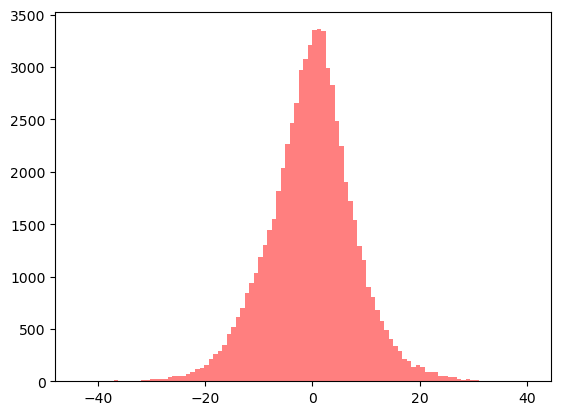

In [5]:
# Distribución datos después de pretrain
_ = plt.hist(Zpretrain.reshape(-1), bins = 100, color = 'red', alpha = 0.5)

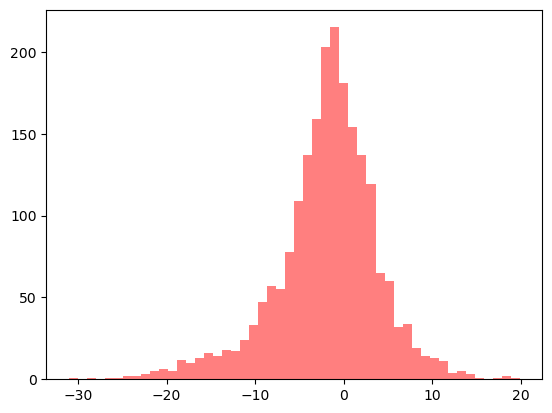

In [6]:
# Distribución de alguna dimensión después de pretrain
dim = np.random.choice(range(32))
_ = plt.hist(Zpretrain[:,dim], bins = 50, color = 'red', alpha = 0.5)

## GMM vs KMeans

#### KMEANS

In [7]:
kMeans = KMeans(n_clusters=9, random_state=0)
kMeans.fit(Zpretrain)

#predictions from kmeans
labels = kMeans.predict(Zpretrain)

accuracy = np.round(cluster_acc(y_true = y, y_pred = labels), 5)
nmi = np.round(metrics.normalized_mutual_info_score(y, labels), 5)
ari = np.round(metrics.adjusted_rand_score(y, labels), 5)

print(f'Metrics for KMeans ACC: {accuracy} NMI: {nmi} ARI: {ari}')

Metrics for KMeans ACC: 0.81381 NMI: 0.75604 ARI: 0.77323


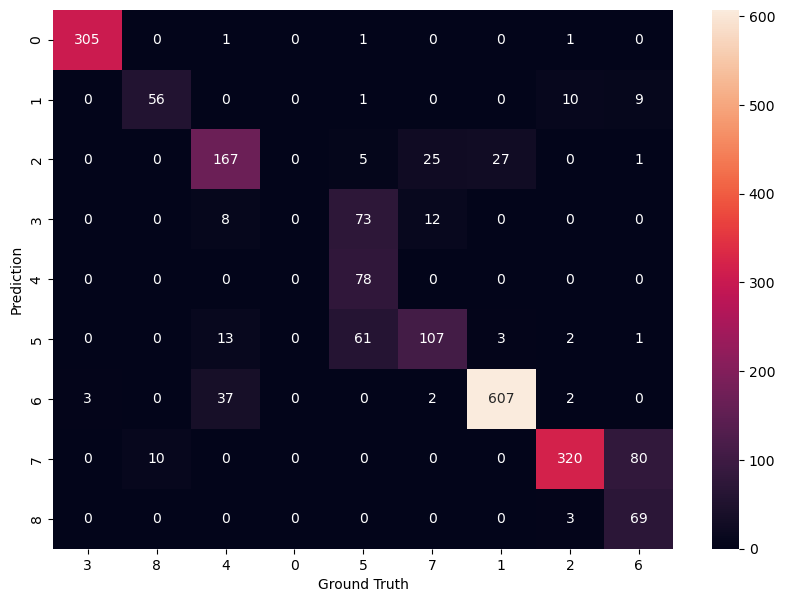

In [8]:
heatmap(y_true = y, y_pred = labels)

#### GMM

In [9]:
gmm = GaussianMixture(n_components=8,random_state=0 )
gmm.fit(Zpretrain)

#predictions from gmm
labels = gmm.predict(Zpretrain)

accuracy = np.round(cluster_acc(y_true = y, y_pred = labels), 5)
nmi = np.round(metrics.normalized_mutual_info_score(y, labels), 5)
ari = np.round(metrics.adjusted_rand_score(y, labels), 5)

print(f'Metrics for KMeans GMM: ACC {accuracy} NMI: {nmi} ARI: {ari}')

Metrics for KMeans GMM: ACC 0.71333 NMI: 0.6827 ARI: 0.6586


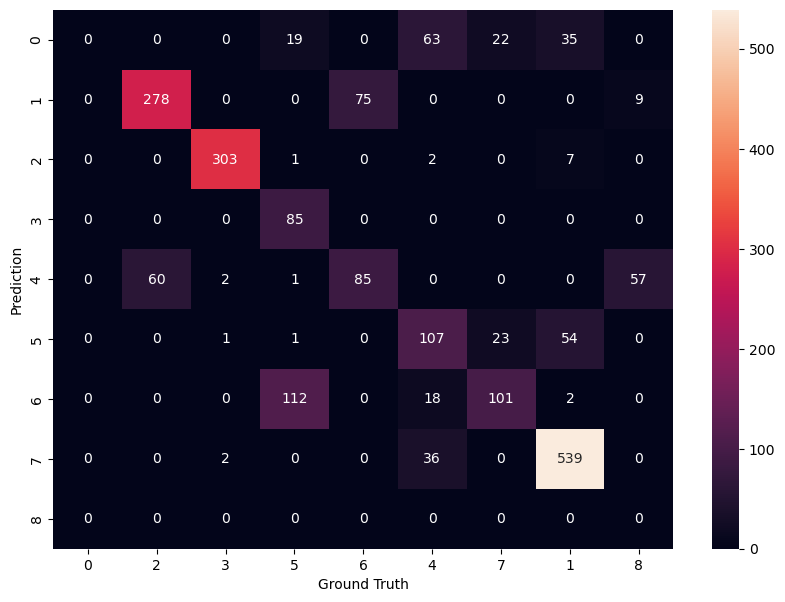

In [10]:
heatmap(y_true = y, y_pred = labels)

## AgglomerativeClustering

In [11]:
ac = AgglomerativeClustering(n_clusters=8)
ac.fit(Zpretrain)

#predictions from gmm
labels = ac.labels_

accuracy = np.round(cluster_acc(y_true = y, y_pred = labels), 5)
nmi = np.round(metrics.normalized_mutual_info_score(y, labels), 5)
ari = np.round(metrics.adjusted_rand_score(y, labels), 5)

print(f'Metrics for AggClustering: ACC {accuracy} NMI: {nmi} ARI: {ari}')

Metrics for AggClustering: ACC 0.76524 NMI: 0.72444 ARI: 0.68077


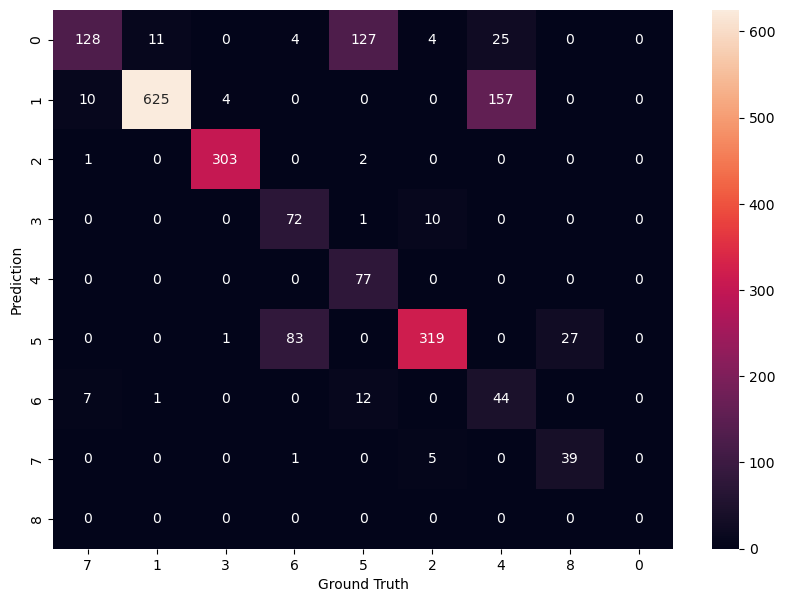

In [12]:
heatmap(y_true = y, y_pred = labels)

## Resultados de la red

#### Fijando la matriz de covarianza como la identidad

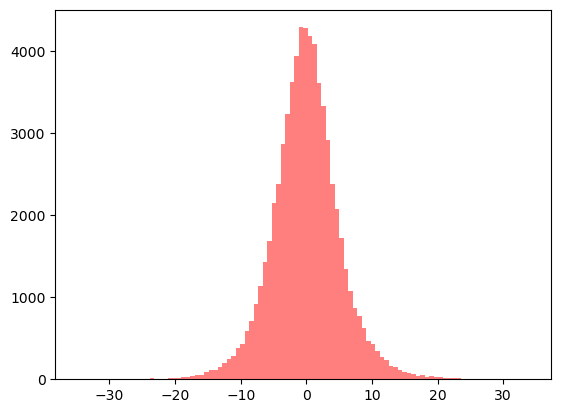

In [13]:
# Lectura de los datos después del entrenamiento 
with open('results_MR_COVIdentidad/DATOS_DESPUES_KMEANS199.pickle', 'rb') as handle:
    datos_final_entrenamiento = pickle.load(handle) 

# Lectura de los datos después del entrenamiento 
last_checkpoint = torch.load('results_MR_COVIdentidad/FTcheckpoint_191.pth.tar') 

# Distribución datos después de pretrain
_ = plt.hist(datos_final_entrenamiento.reshape(-1), bins = 100, color = 'red', alpha = 0.5)

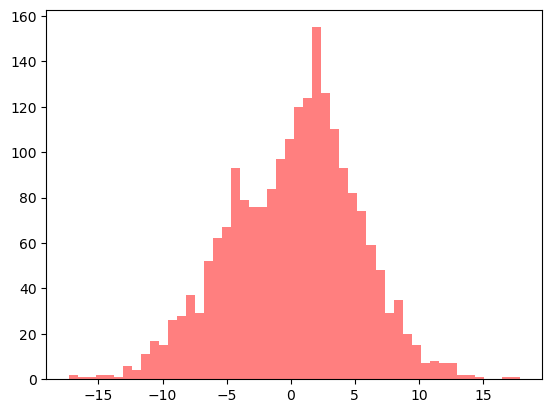

In [14]:
# Distribución de alguna dimensión después de pretrain
_ = plt.hist(datos_final_entrenamiento[:,dim], bins = 50, color = 'red', alpha = 0.5)

Text(0.5, 1.0, 'Pesos reales')

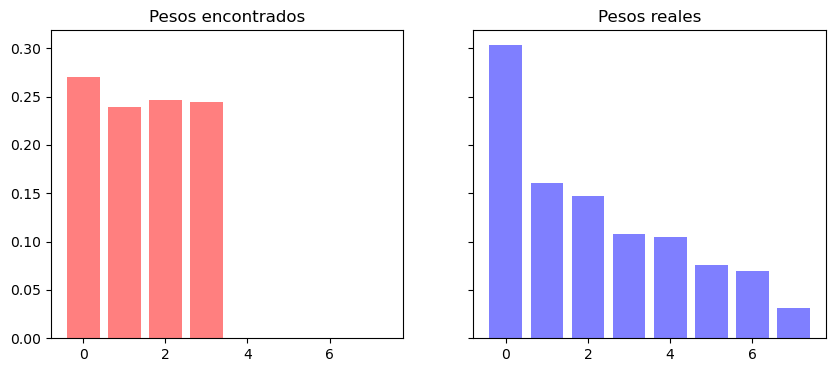

In [15]:
# Pesos dados a los clusters
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize = (10,4))

ax1.bar(x = range(8), height = last_checkpoint['pi'].detach().numpy().reshape(-1), color = 'red', alpha = 0.5)
ax1.set_title('Pesos encontrados')

nique, counts = np.unique(y, return_counts=True)
ax2.bar(x = range(8), height = counts/np.sum(counts), color = 'blue', alpha = 0.5)
ax2.set_title('Pesos reales')

In [16]:
# Resultados: distribución encontrada
distr = np.array(find_probabilities(datos_final_entrenamiento, last_checkpoint['mu'] , [np.identity(32)]*8))
for i in range(distr.shape[0]): distr[i,:] = distr[i,:]/np.sum(distr[i,:])
distr 

array([[0.00000000e+00, 8.77874814e-18, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.00000000e+00, 1.02838328e-54, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

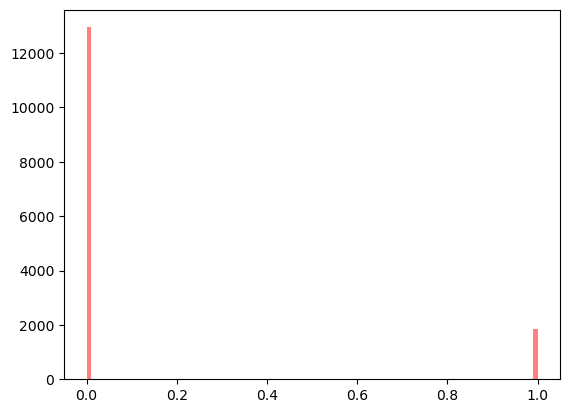

In [17]:
_ = plt.hist(distr.reshape(-1), bins = 100, color = 'red', alpha = 0.5)

In [18]:
# Resultados: clusters asignados
labels = torch.argmax(torch.tensor(distr), dim=1).data.cpu().numpy()


accuracy = np.round(cluster_acc(y_true = y, y_pred = labels), 5)
nmi = np.round(metrics.normalized_mutual_info_score(y, labels), 5)
ari = np.round(metrics.adjusted_rand_score(y, labels), 5)

print(f'Metrics for NN: ACC {accuracy} NMI: {nmi} ARI: {ari}')

Metrics for NN: ACC 0.66762 NMI: 0.58268 ARI: 0.52172


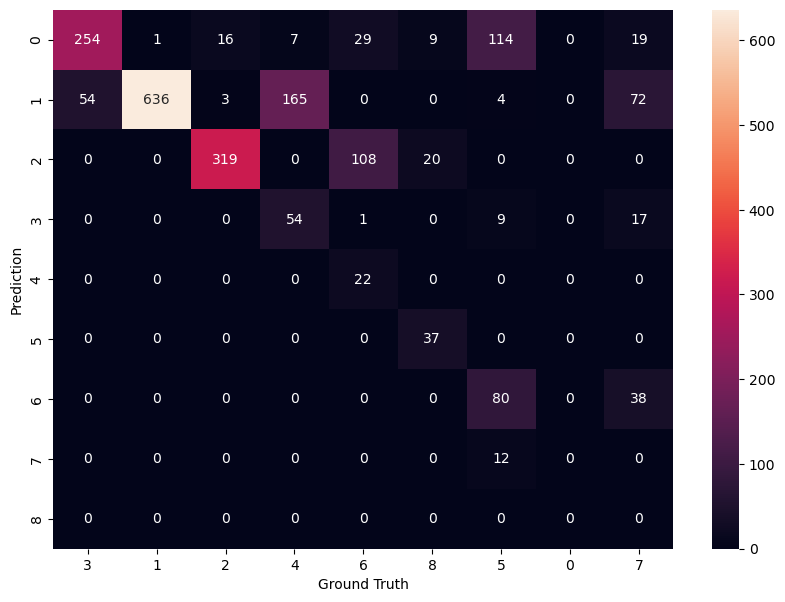

In [19]:
heatmap(y_true = y, y_pred = labels)

#### Modificando las matrices de covarianza

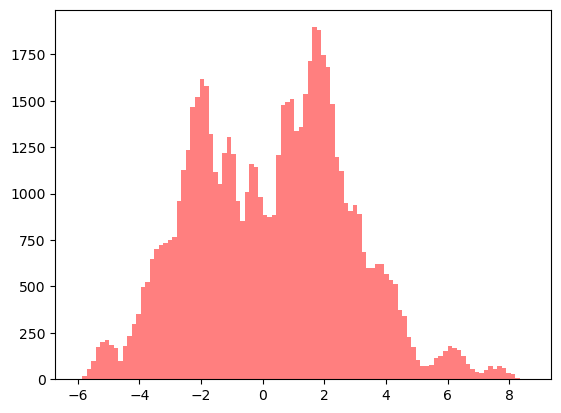

In [38]:
# Lectura de los datos después del entrenamiento 
with open('results_MR_COVDiagonal2/DATOS_DESPUES_KMEANS499.pickle', 'rb') as handle:
    datos_final_entrenamiento = pickle.load(handle) 

# Lectura de los datos después del entrenamiento 
last_checkpoint = torch.load('results_MR_COVDiagonal2/FTcheckpoint_500.pth.tar') 

# Distribución datos después de pretrain
_ = plt.hist(datos_final_entrenamiento.reshape(-1), bins = 100, color = 'red', alpha = 0.5)

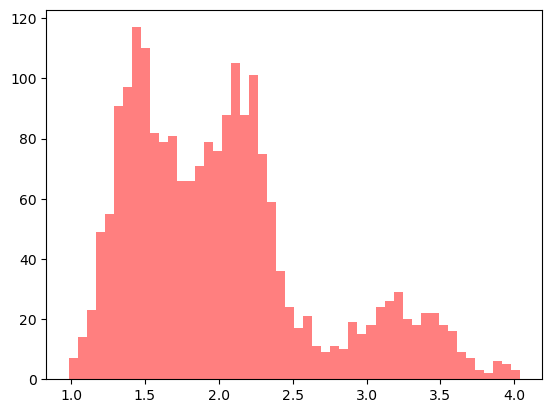

In [39]:
# Distribución de alguna dimensión después de pretrain
_ = plt.hist(datos_final_entrenamiento[:,dim], bins = 50, color = 'red', alpha = 0.5)

Text(0.5, 1.0, 'Pesos reales')

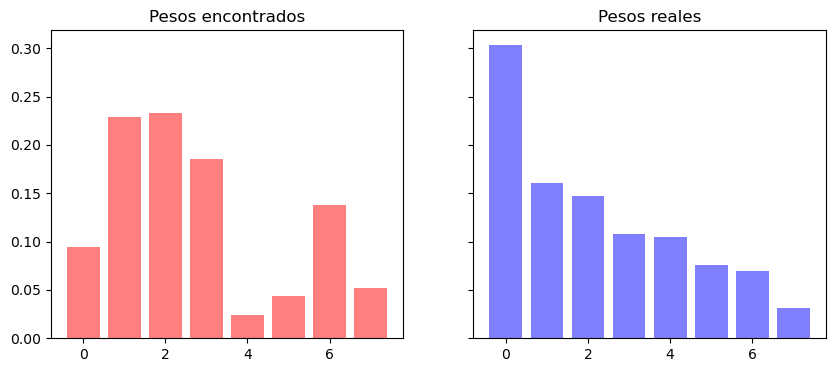

In [40]:
# Pesos dados a los clusters
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize = (10,4))

pi = last_checkpoint['pi'].detach().numpy().reshape(-1)
ax1.bar(x = range(8), height = pi/np.sum(pi), color = 'red', alpha = 0.5)
ax1.set_title('Pesos encontrados')

nique, counts = np.unique(y, return_counts=True)
ax2.bar(x = range(8), height = counts/np.sum(counts), color = 'blue', alpha = 0.5)
ax2.set_title('Pesos reales')

In [41]:
counts/np.sum(counts)

array([0.30333333, 0.16095238, 0.14666667, 0.10761905, 0.10428571,
       0.07619048, 0.06952381, 0.03142857])

In [42]:
# Resultados: distribución encontrada
distr = np.array(find_probabilities(datos_final_entrenamiento, last_checkpoint['mu'], last_checkpoint['cov']))# [np.identity(32)]*8))
for i in range(distr.shape[0]): distr[i,:] = distr[i,:]/np.sum(distr[i,:])
distr

array([[9.49447216e-306, 1.20413925e-013, 3.69759351e-092, ...,
        5.92433097e-178, 5.29311171e-045, 5.61091789e-145],
       [0.00000000e+000, 2.44813965e-011, 3.18861747e-151, ...,
        6.70952109e-158, 1.00000000e+000, 7.34695809e-289],
       [1.00000000e+000, 0.00000000e+000, 2.61018620e-247, ...,
        2.24535256e-075, 0.00000000e+000, 0.00000000e+000],
       ...,
       [9.96055209e-287, 2.60459580e-117, 1.00000000e+000, ...,
        4.86666375e-135, 2.22689475e-198, 4.10786721e-061],
       [0.00000000e+000, 9.99994526e-001, 5.03228356e-128, ...,
        1.98369939e-135, 5.47394455e-006, 4.95283313e-222],
       [4.68304987e-285, 9.99720014e-001, 9.63462288e-087, ...,
        1.98370016e-125, 2.89958646e-034, 6.49917479e-120]])

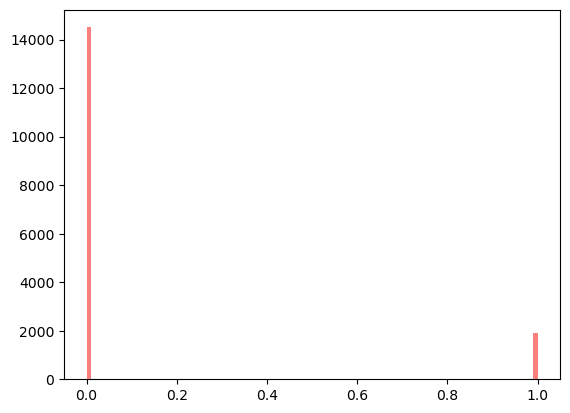

In [43]:
_ = plt.hist(distr.reshape(-1), bins = 100, color = 'red', alpha = 0.5)

In [44]:
# Resultados: clusters asignados
labels = torch.argmax(torch.tensor(distr), dim=1).data.cpu().numpy()

accuracy = np.round(cluster_acc(y_true = y, y_pred = labels), 5)
nmi = np.round(metrics.normalized_mutual_info_score(y, labels), 5)
ari = np.round(metrics.adjusted_rand_score(y, labels), 5)

print(f'Metrics for NN: ACC {accuracy} NMI: {nmi} ARI: {ari}')

Metrics for NN: ACC 0.76333 NMI: 0.7429 ARI: 0.63599


In [45]:
last_checkpoint['cov'][0].diag()

tensor([0.6235, 0.9295, 0.6283, 0.2845, 0.4438, 0.0164, 0.0330, 0.1504, 0.0668,
        0.1050, 0.5766, 0.3515, 0.4668, 0.4531, 0.0780, 0.1393, 0.0761, 0.7512,
        0.5092, 0.1624, 0.6517, 0.9655, 0.9557, 0.9063, 0.3699, 0.5339, 0.4666,
        0.7165, 0.4778, 0.8004, 0.5117, 0.0141], dtype=torch.float64)

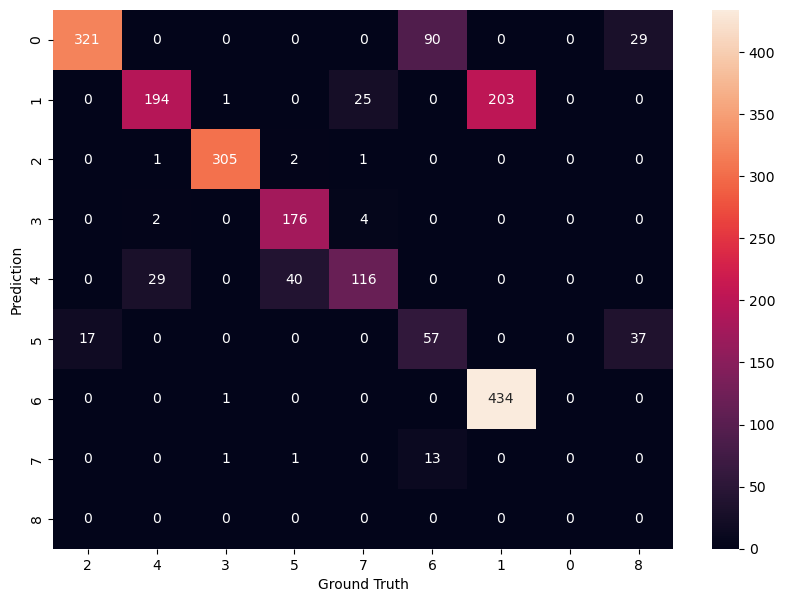

In [46]:
heatmap(y_true = y, y_pred = labels)

# Prueba con cambio de distancia

In [17]:
from nltk.cluster.kmeans import KMeansClusterer
from scipy.stats import pearsonr
from tqdm import tqdm

In [18]:
def calculate_matrix_distance(data, weight):
    euclidean_distances = np.zeros((len(data), len(data)))
    pearson_distances = np.zeros((len(data), len(data)))
    for i in tqdm(range(len(data))):
        point_i = data[i,:]
        for j in range(i,len(data)):
            point_j = data[j,:]
            euclidean_distance = np.linalg.norm(point_i-point_j)
            euclidean_distances[i,j] = euclidean_distance
            euclidean_distances[j,i] = euclidean_distance # Simetría

            pearson_distance = 1-pearsonr(point_i, point_j)[0]
            pearson_distances[i,j] = pearson_distance
            pearson_distances[j,i] = pearson_distance # Simetría

    # Normalización min-max de las matrices obtenidas
    euclidean_distances = (euclidean_distances-np.min(euclidean_distances))/(
                                np.max(euclidean_distances) - np.min(euclidean_distances))
    pearson_distances = (pearson_distances-np.min(pearson_distances))/(
                                np.max(pearson_distances) - np.min(pearson_distances))

    custom_distance_matrix = weight*euclidean_distances + (1-weight)*pearson_distances
    return custom_distance_matrix, np.max(euclidean_distances), np.min(euclidean_distances),   np.max(pearson_distances),  np.min(pearson_distances)

In [38]:
NUM_CLUSTERS = 8
data = Zpretrain

custom_distance_matrix, maxe, mine, maxp, minp = calculate_matrix_distance(data, weight = 0.5)

In [39]:
# Es simétrica
(custom_distance_matrix==custom_distance_matrix.T).all()

True

<AxesSubplot: >

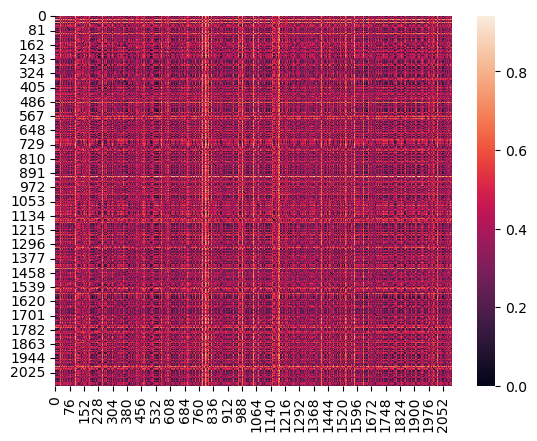

In [40]:
sns.heatmap(custom_distance_matrix)

In [ ]:
def custom_distance(v, u, weight = 0.5, maxe = maxe, mine = mine, maxp = maxp, minp = minp):
    euclidean_distance = np.linalg.norm(v-u)
    euclidean_distance = (euclidean_distance-mine)/(maxe-mine)
    pearson_distance = 1-pearsonr(v, u)[0]
    pearson_distance = (pearson_distance-minp)/(maxp-minp)

    return weight*euclidean_distance + (1-weight)*pearson_distance

In [42]:
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance = custom_distance, repeats=25)
assigned_clusters = kclusterer.cluster(data, assign_clusters=True)

In [47]:
assigned_clusters = np.array(assigned_clusters)

In [48]:
accuracy = np.round(cluster_acc(y_true = y, y_pred = assigned_clusters), 5)
nmi = np.round(metrics.normalized_mutual_info_score(y, assigned_clusters), 5)
ari = np.round(metrics.adjusted_rand_score(y, assigned_clusters), 5)

print(f'Metrics for NN: ACC {accuracy} NMI: {nmi} ARI: {ari}')

Metrics for NN: ACC 0.76429 NMI: 0.74163 ARI: 0.73663


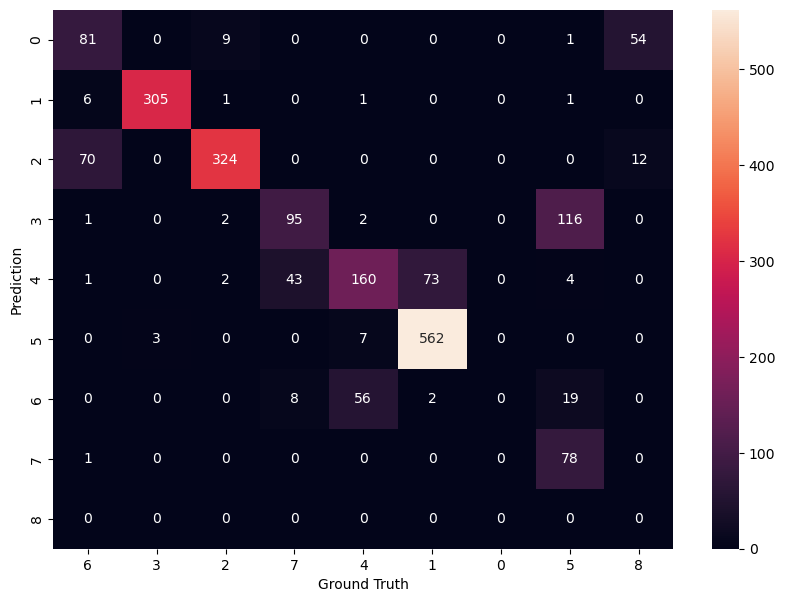

In [49]:
heatmap(y_true = y, y_pred = assigned_clusters)

In [52]:
def clustering_weight(w):
    def custom_distance_w(v, u, weight = w, maxe = maxe, mine = mine, maxp = maxp, minp = minp):
        euclidean_distance = np.linalg.norm(v-u)
        euclidean_distance = (euclidean_distance-mine)/(maxe-mine)
        pearson_distance = 1-pearsonr(v, u)[0]
        pearson_distance = (pearson_distance-minp)/(maxp-minp)

        return weight*euclidean_distance + (1-weight)*pearson_distance

    kclusterer = KMeansClusterer(NUM_CLUSTERS, distance = custom_distance_w, repeats=25)
    assigned_clusters = kclusterer.cluster(data, assign_clusters=True)
    assigned_clusters = np.array(assigned_clusters)
    accuracy = np.round(cluster_acc(y_true = y, y_pred = assigned_clusters), 5)
    nmi = np.round(metrics.normalized_mutual_info_score(y, assigned_clusters), 5)
    ari = np.round(metrics.adjusted_rand_score(y, assigned_clusters), 5)

    return kclusterer, accuracy, nmi, ari 

# Iteramos sobre algunos valores de w 
weights = [0.1*i for i in range(11)]
results = {}
for w in weights:
    kclusterer, accuracy, nmi, ari = clustering_weight(w)
    results[w] = (kclusterer, accuracy, nmi, ari)
    print(f'Peso: {w}. Accuracy: {accuracy}. NMI: {nmi}. ARI: {ari}')

Peso: 0.0. Accuracy: 0.77762. NMI: 0.74634. ARI: 0.75417
Peso: 0.1. Accuracy: 0.65286. NMI: 0.71376. ARI: 0.59874
Peso: 0.2. Accuracy: 0.64143. NMI: 0.70449. ARI: 0.59192
Peso: 0.30000000000000004. Accuracy: 0.64524. NMI: 0.70705. ARI: 0.5902
Peso: 0.4. Accuracy: 0.74286. NMI: 0.7313. ARI: 0.7258
Peso: 0.5. Accuracy: 0.76381. NMI: 0.74374. ARI: 0.7364
Peso: 0.6000000000000001. Accuracy: 0.63905. NMI: 0.7066. ARI: 0.59245
Peso: 0.7000000000000001. Accuracy: 0.7481. NMI: 0.73287. ARI: 0.70213
Peso: 0.8. Accuracy: 0.75714. NMI: 0.73963. ARI: 0.72769


# Cambio de distancia - datos completos 

In [19]:
NUM_CLUSTERS = 8
data = x

custom_distance_matrix, maxe, mine, maxp, minp = calculate_matrix_distance(data, weight = 0.5)

100%|██████████| 2100/2100 [07:26<00:00,  4.70it/s] 


In [20]:
def clustering_weight(num_clusters, w, maxe, mine, maxp, minp):
    def custom_distance_w(v, u, weight = w, maxe = maxe, mine = mine, maxp = maxp, minp = minp):
        euclidean_distance = np.linalg.norm(v-u)
        euclidean_distance = (euclidean_distance-mine)/(maxe-mine)
        pearson_distance = 1-pearsonr(v, u)[0]
        pearson_distance = (pearson_distance-minp)/(maxp-minp)

        return weight*euclidean_distance + (1-weight)*pearson_distance

    kclusterer = KMeansClusterer(num_clusters, distance = custom_distance_w, repeats=25)
    assigned_clusters = kclusterer.cluster(data, assign_clusters=True)
    assigned_clusters = np.array(assigned_clusters)
    accuracy = np.round(cluster_acc(y_true = y, y_pred = assigned_clusters), 5)
    nmi = np.round(metrics.normalized_mutual_info_score(y, assigned_clusters), 5)
    ari = np.round(metrics.adjusted_rand_score(y, assigned_clusters), 5)

    return kclusterer, accuracy, nmi, ari 

In [21]:
# Iteramos sobre algunos valores de w 
weights = [0.1*i for i in range(11)]
results = {}
for w in tqdm(weights):
    kclusterer, accuracy, nmi, ari = clustering_weight(8, w,  maxe, mine, maxp, minp)
    results[w] = (kclusterer, accuracy, nmi, ari)
    print(f'Peso: {w}. Accuracy: {accuracy}. NMI: {nmi}. ARI: {ari}')

  9%|▉         | 1/11 [32:10<5:21:47, 1930.71s/it]

Peso: 0.0. Accuracy: 0.59619. NMI: 0.53249. ARI: 0.41402


 18%|█▊        | 2/11 [1:26:27<6:46:34, 2710.51s/it]

Peso: 0.1. Accuracy: 0.45476. NMI: 0.36613. ARI: 0.24482


 27%|██▋       | 3/11 [2:23:14<6:43:51, 3028.91s/it]

Peso: 0.2. Accuracy: 0.38429. NMI: 0.33284. ARI: 0.19345


 36%|███▋      | 4/11 [3:11:43<5:47:50, 2981.45s/it]

Peso: 0.30000000000000004. Accuracy: 0.4419. NMI: 0.36798. ARI: 0.22332


 45%|████▌     | 5/11 [3:58:43<4:52:18, 2923.16s/it]

Peso: 0.4. Accuracy: 0.38333. NMI: 0.33332. ARI: 0.19407


 55%|█████▍    | 6/11 [4:45:57<4:01:04, 2893.00s/it]

Peso: 0.5. Accuracy: 0.44143. NMI: 0.36782. ARI: 0.22321


 64%|██████▎   | 7/11 [5:27:23<3:03:59, 2759.79s/it]

Peso: 0.6000000000000001. Accuracy: 0.44143. NMI: 0.36793. ARI: 0.22337


 73%|███████▎  | 8/11 [6:13:41<2:18:17, 2765.72s/it]

Peso: 0.7000000000000001. Accuracy: 0.44143. NMI: 0.35984. ARI: 0.23641


 82%|████████▏ | 9/11 [6:57:06<1:30:30, 2715.47s/it]

Peso: 0.8. Accuracy: 0.44. NMI: 0.35942. ARI: 0.23623


 91%|█████████ | 10/11 [7:40:43<44:45, 2685.08s/it] 

Peso: 0.9. Accuracy: 0.43952. NMI: 0.35935. ARI: 0.23613


100%|██████████| 11/11 [8:21:51<00:00, 2737.38s/it]

Peso: 1.0. Accuracy: 0.44238. NMI: 0.36821. ARI: 0.2235


# PCA + KMeans

In [32]:
from sklearn.decomposition import PCA

In [37]:
pca = PCA(n_components=32)
Xpca = pca.fit_transform(x)

Text(0.5, 1.0, 'Varianza')

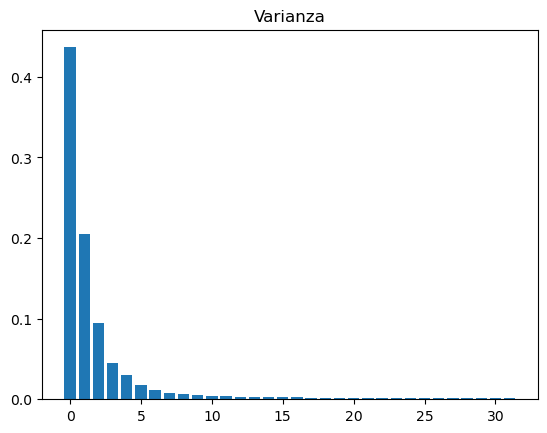

In [40]:
plt.bar(x = range(32), height=pca.explained_variance_ratio_)
plt.title('Varianza')

In [45]:
Xpca.shape

(2100, 32)

In [41]:
kmeans = KMeans(n_clusters=8, random_state=0)
Ypca = kmeans.fit_predict(Xpca)

In [42]:
# Resultados: clusters asignados
accuracy = np.round(cluster_acc(y_true = y, y_pred = Ypca), 5)
nmi = np.round(metrics.normalized_mutual_info_score(y, Ypca), 5)
ari = np.round(metrics.adjusted_rand_score(y, Ypca), 5)

print(f'Metrics for NN: ACC {accuracy} NMI: {nmi} ARI: {ari}')

Metrics for NN: ACC 0.39429 NMI: 0.33609 ARI: 0.19391


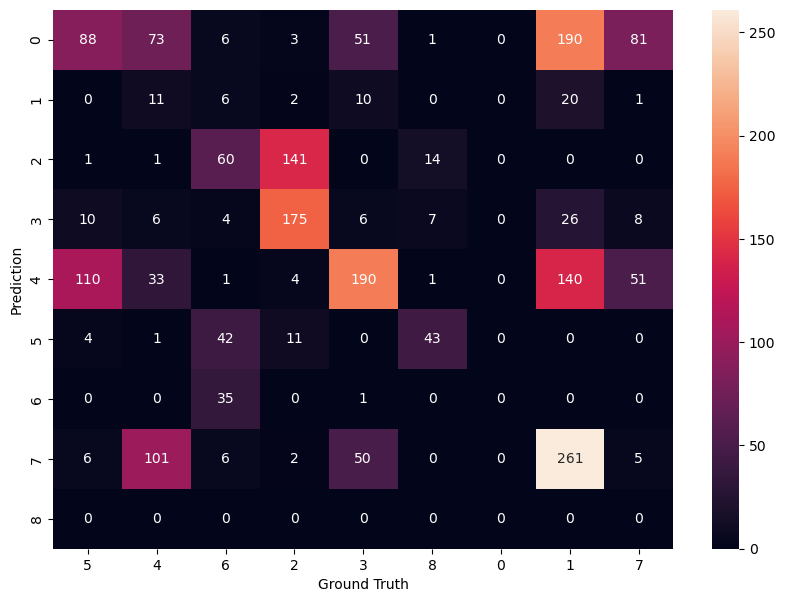

In [43]:
heatmap(y_true = y, y_pred = Ypca)

# Gráficos por épocas

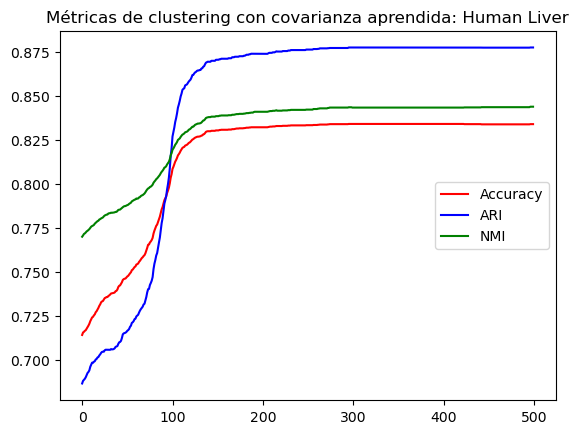

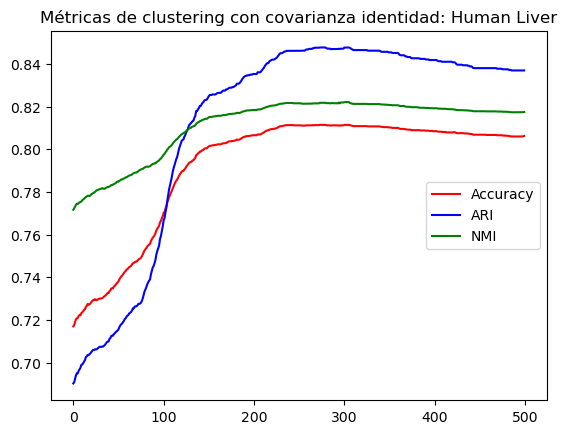

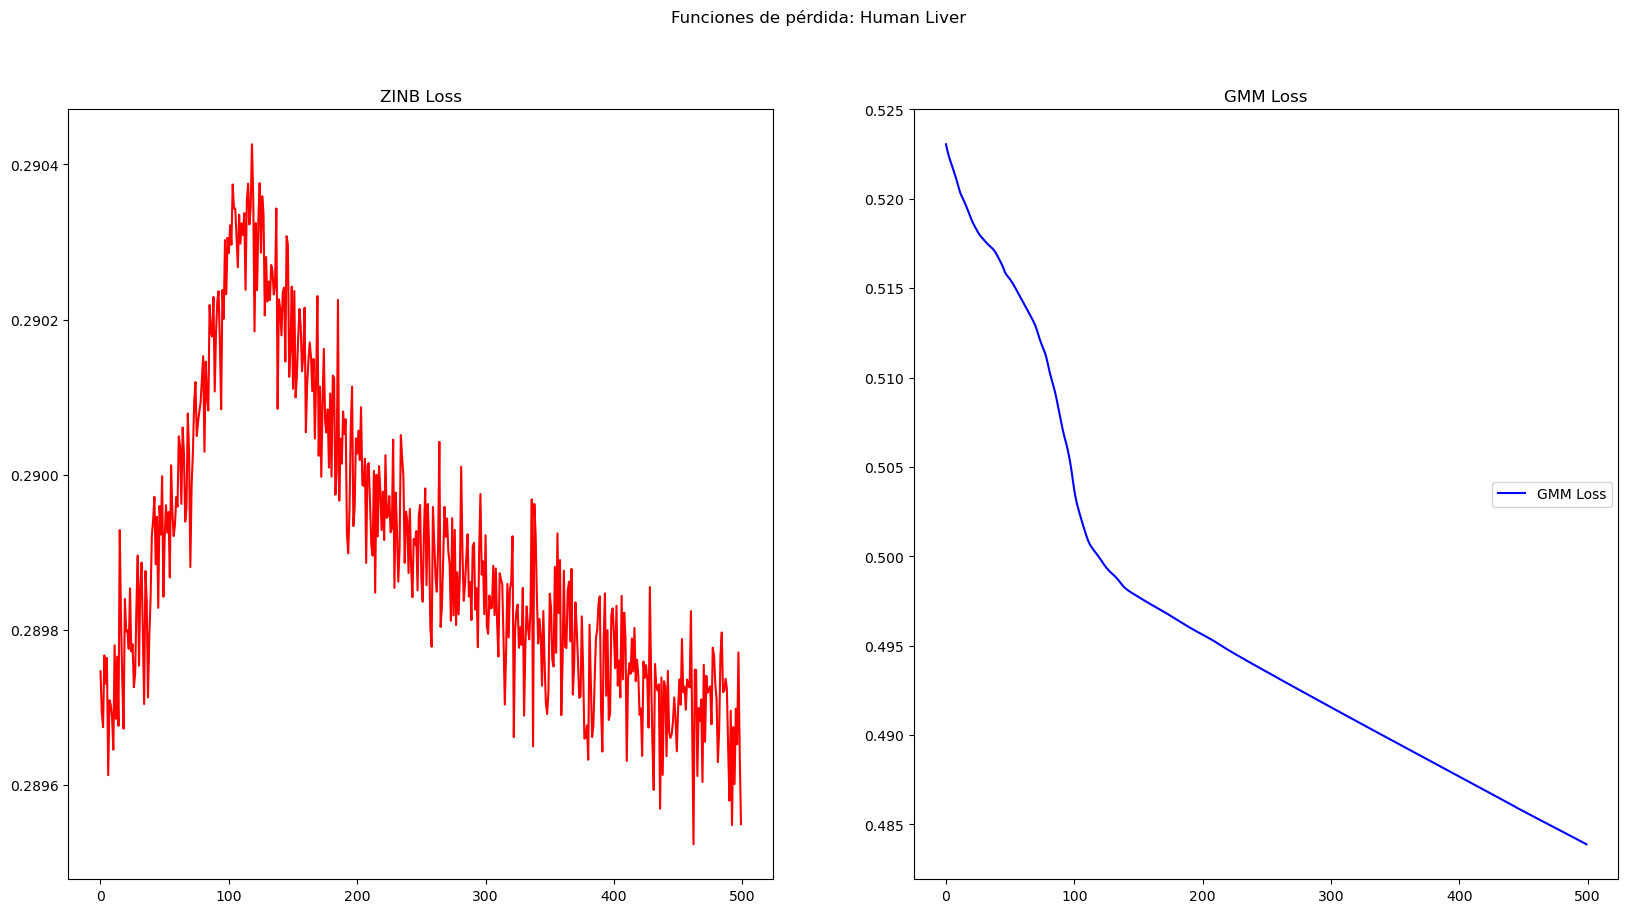

In [7]:
path = 'results/HumanLiver/'
plot_results(path, 'Human Liver')

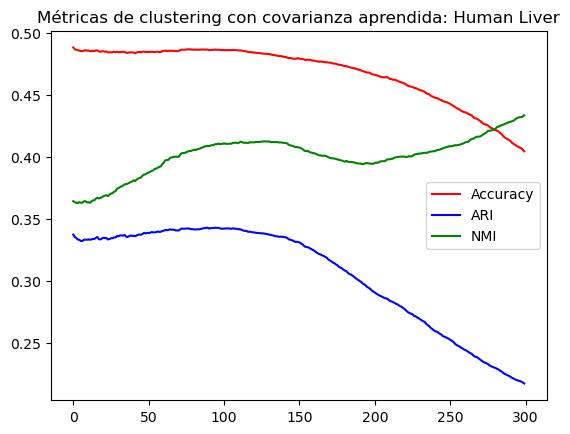

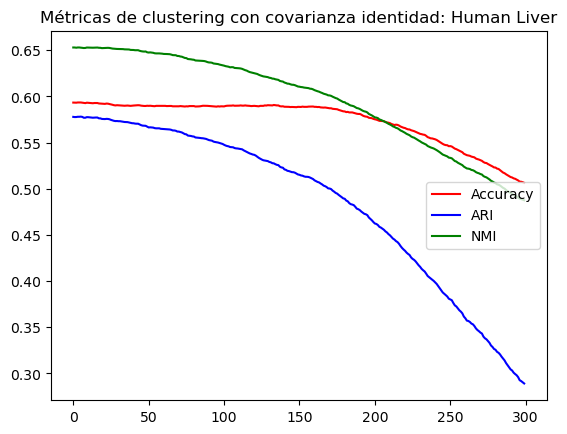

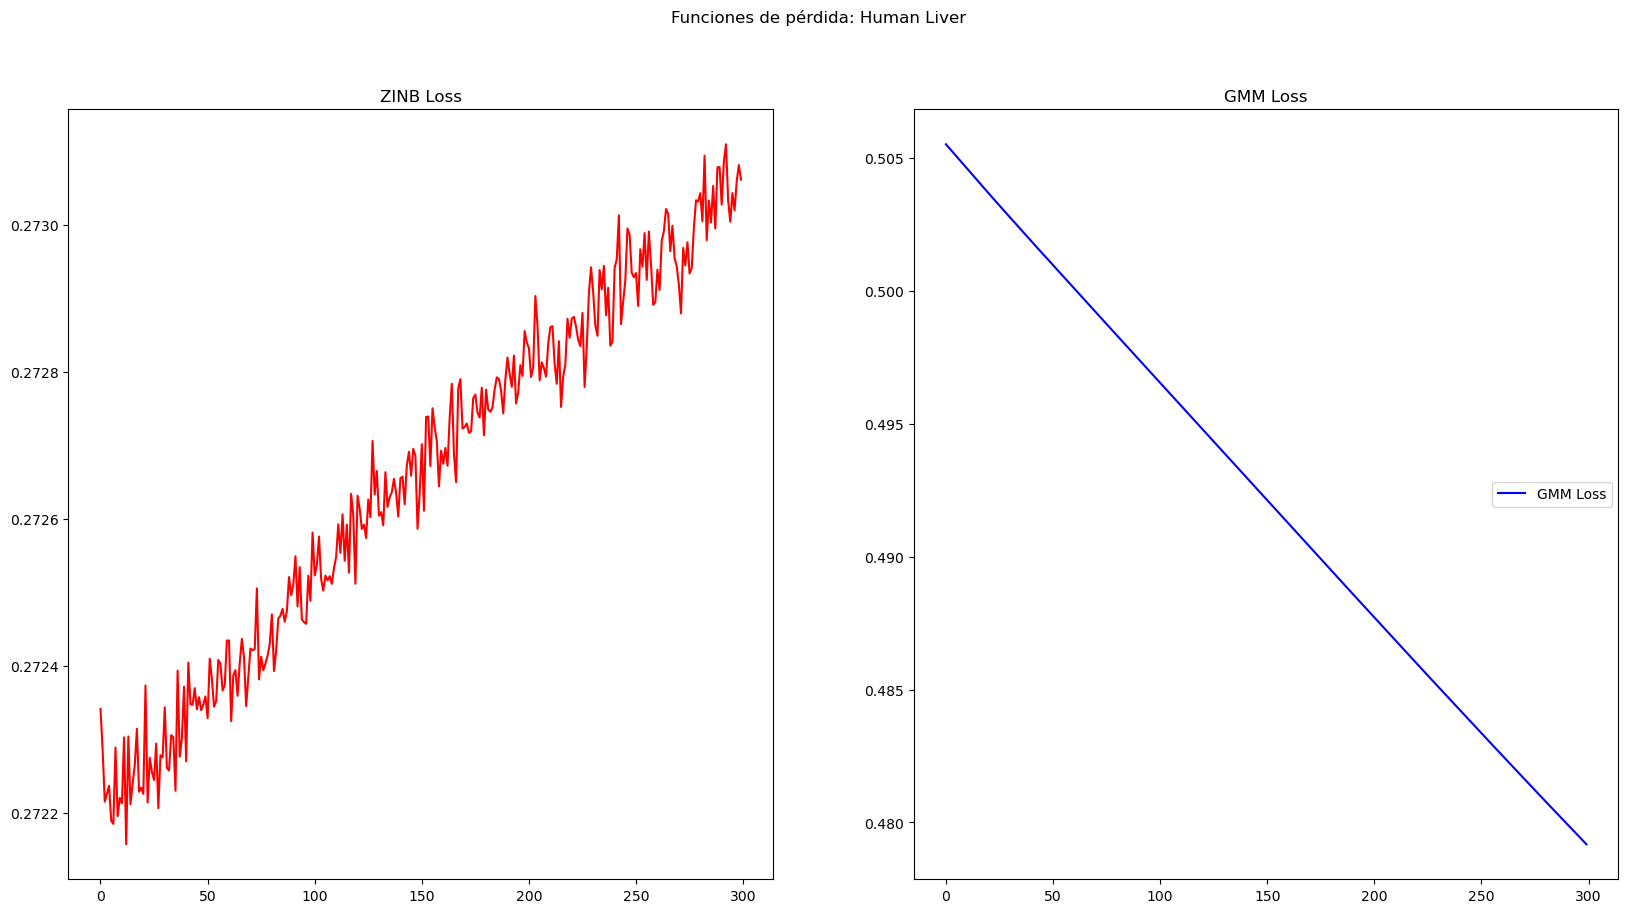

In [8]:
path = 'results/pruebasNAN/HumanLiver/'
plot_results(path, 'Human Liver')

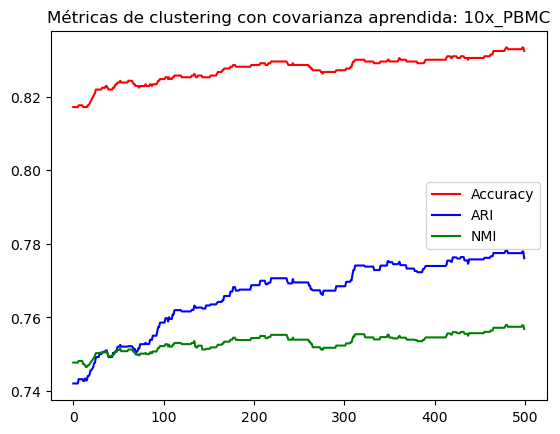

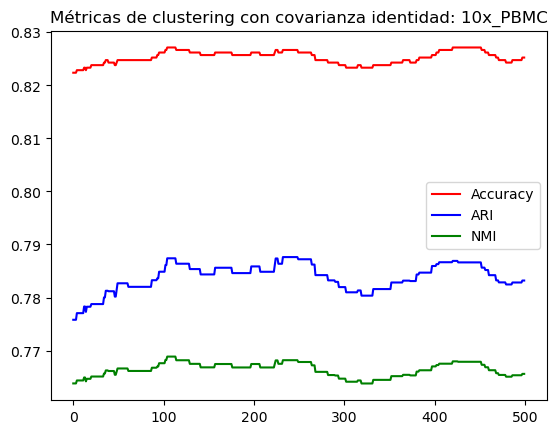

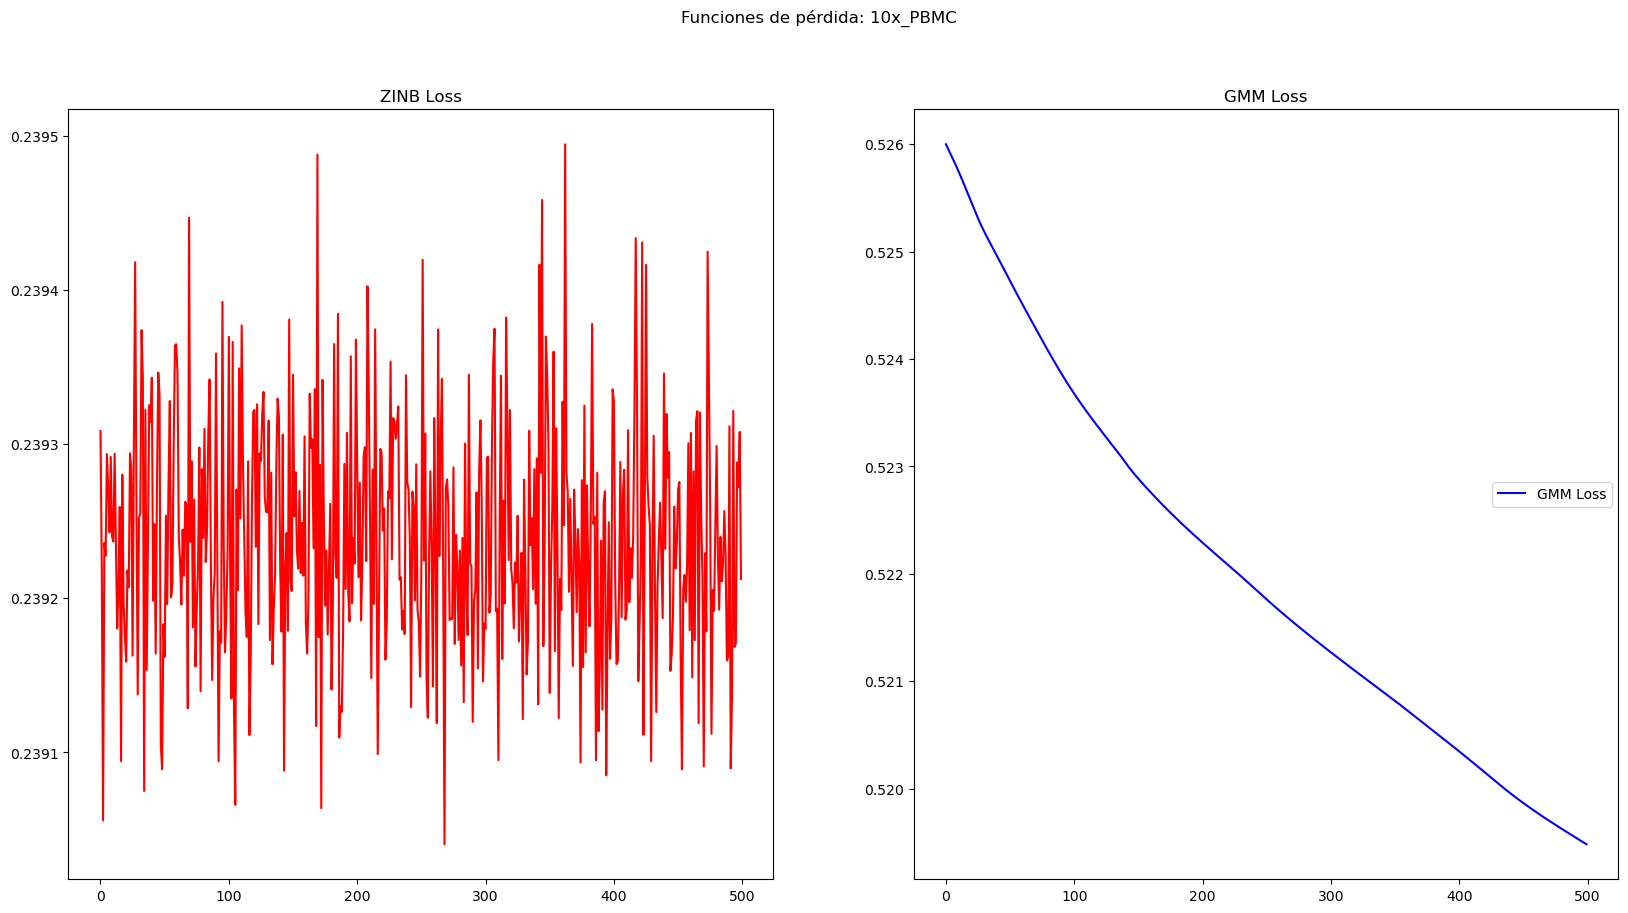

In [9]:
path = 'results_MR_COVDiagonal2//'
plot_results(path, '10x_PBMC')

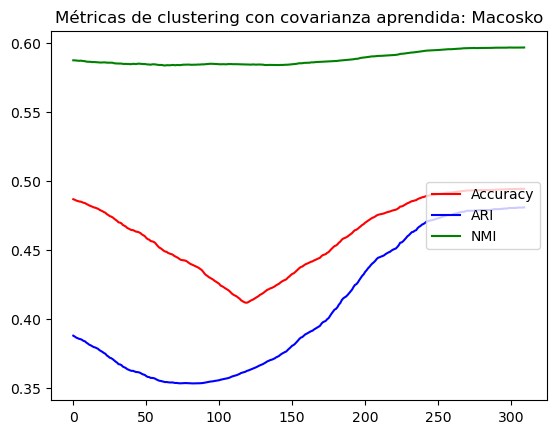

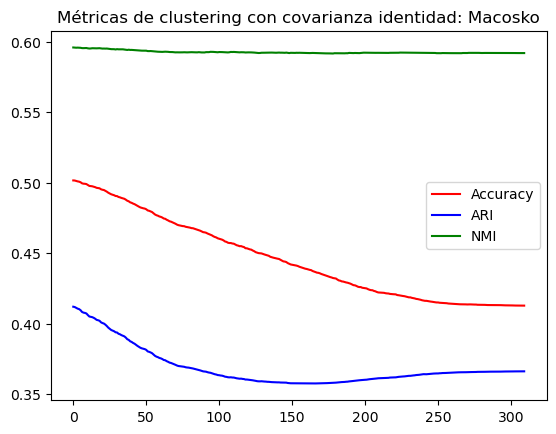

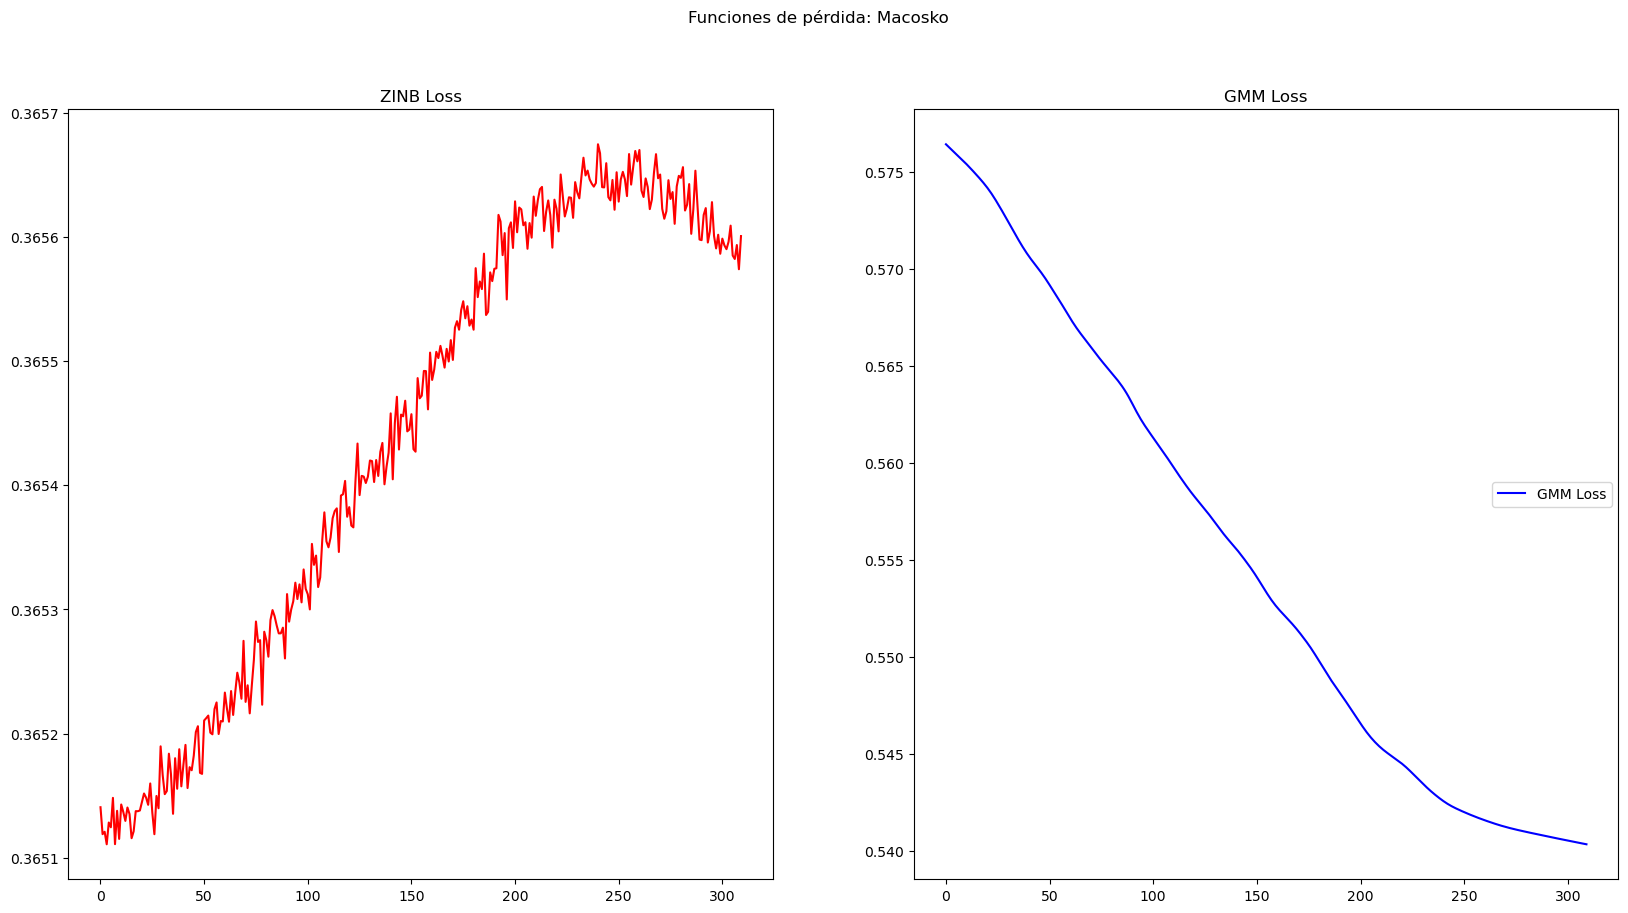

In [19]:
path = 'results/Macosko/' #results_MR_COVDiagonal2/'
plot_results(path, 'Macosko')

# Resultados 15/06/2023

### 10x_PBMC

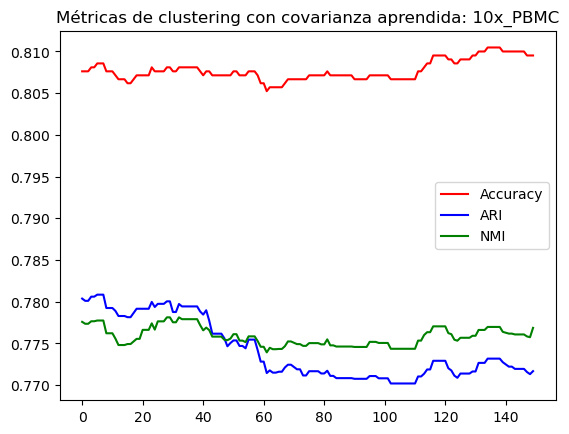

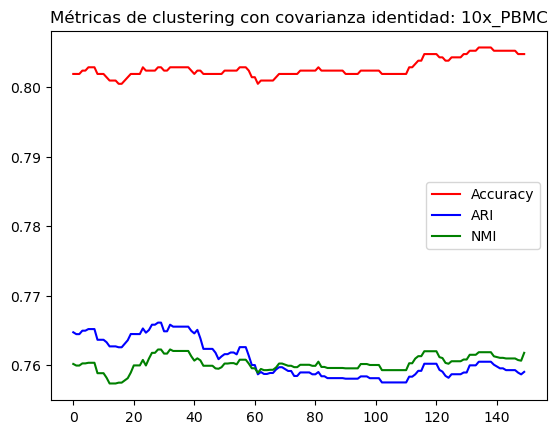

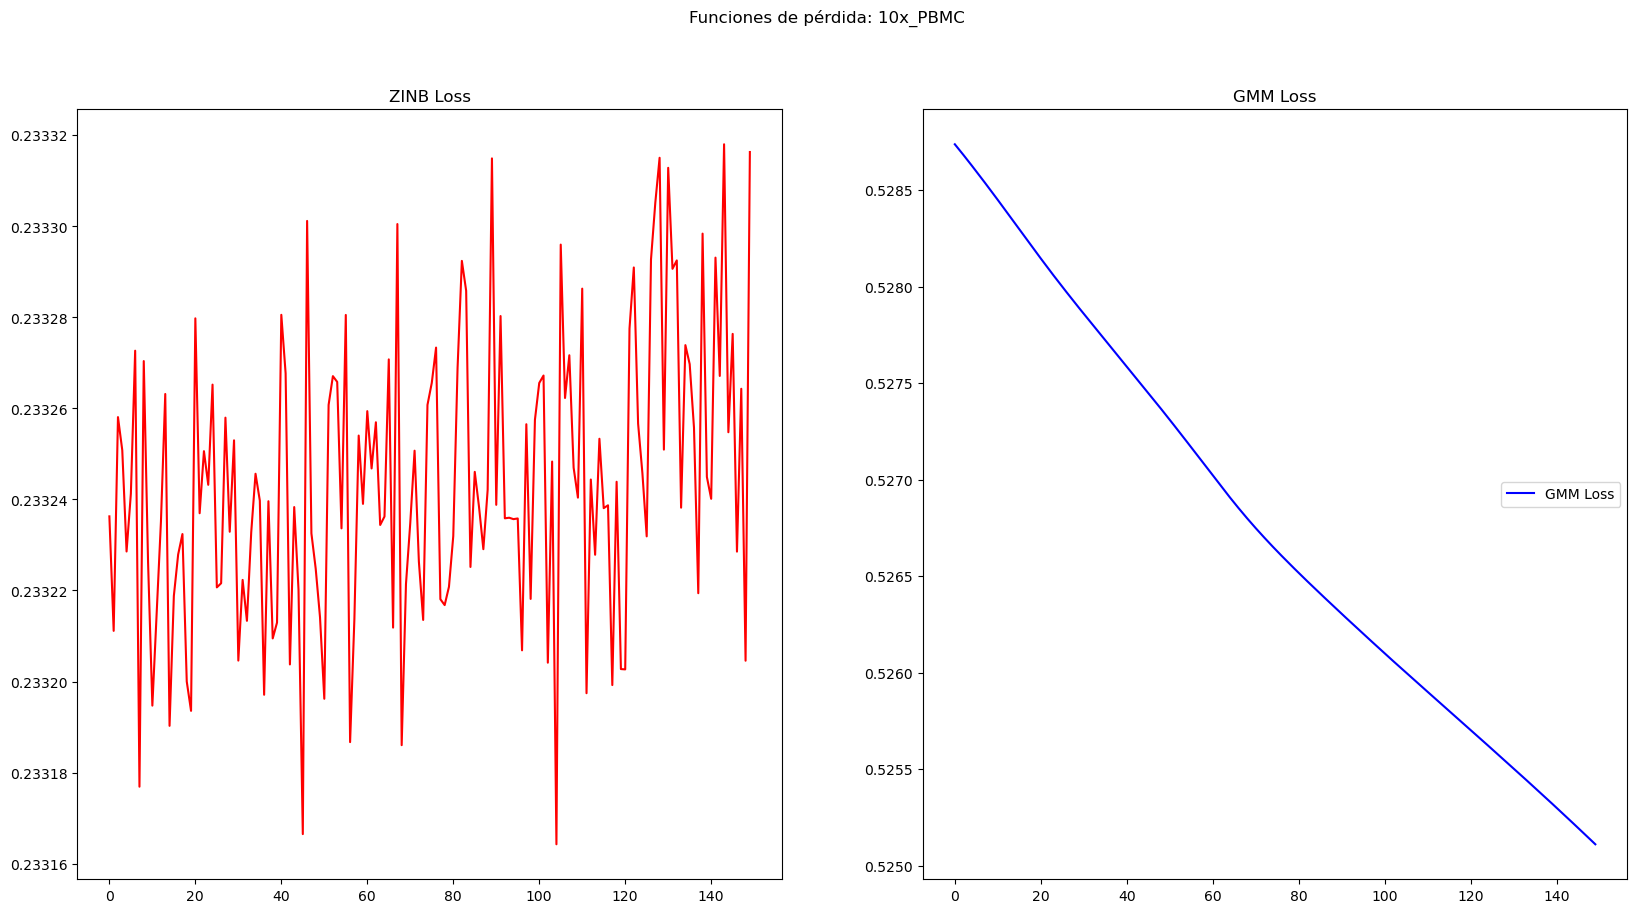

In [8]:
plot_results('results/10x_PBMC_0605/', '10x_PBMC')

In [21]:
with open('results/10x_PBMC_0605/prediccion.pickle', 'rb') as f:
    pred = pickle.load(f)

# Lectura de los datos y clusters reales
data_mat = h5py.File('data/Small_Datasets/10X_PBMC_select_2100.h5')
x = np.array(data_mat['X'])
y = np.array(data_mat['Y'])

print(f'Accuracy: {cluster_acc(y,pred)}')

Accuracy: 0.8095238095238095


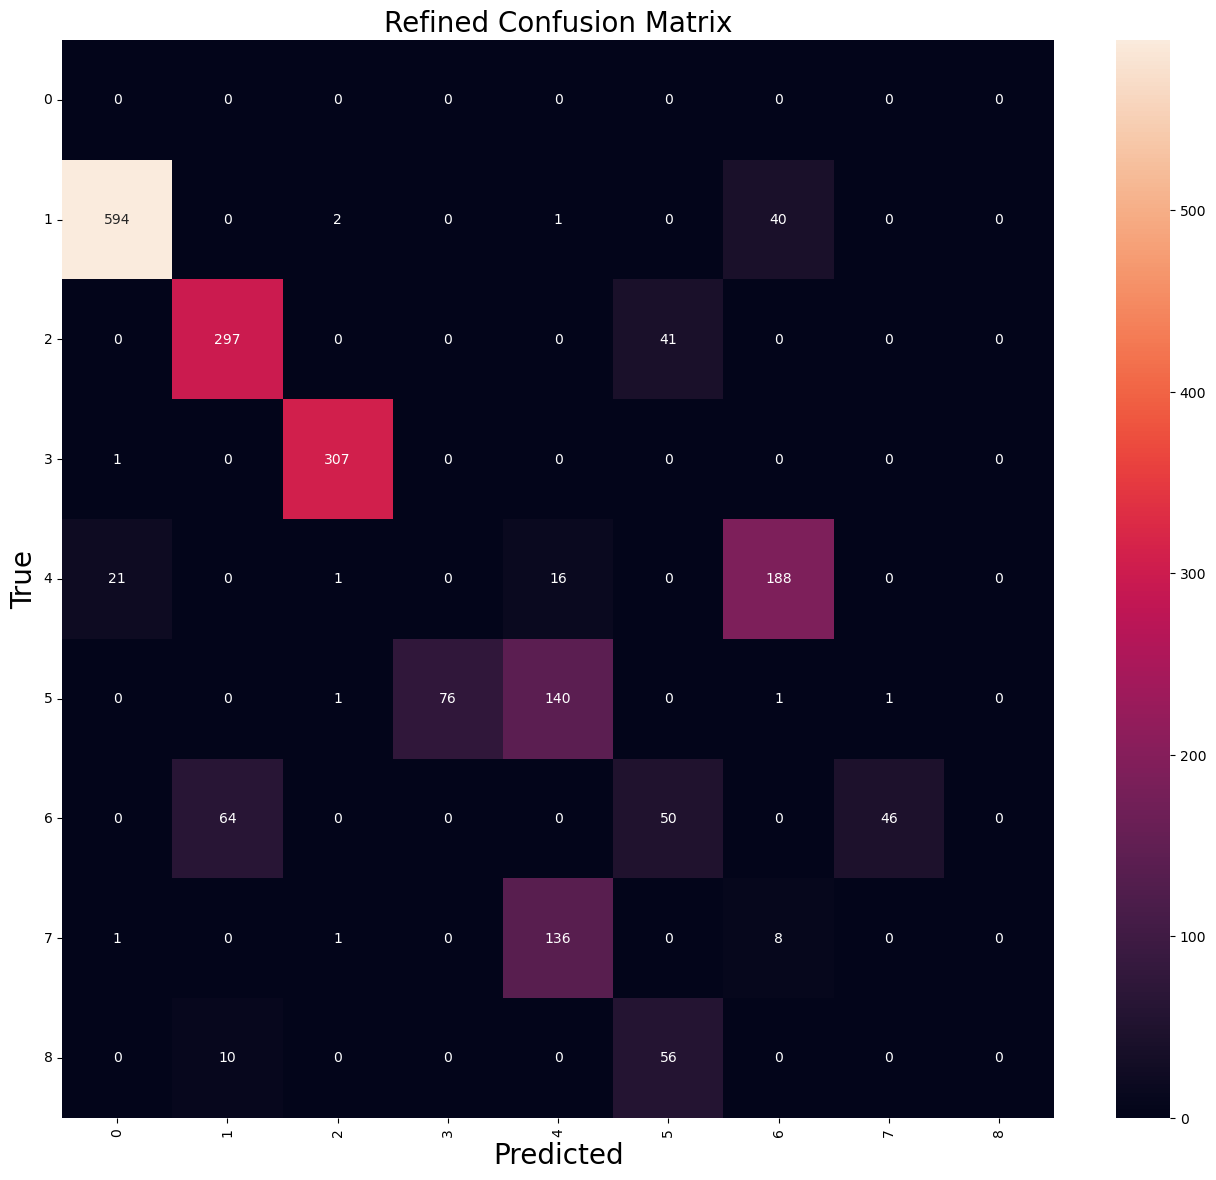

In [18]:
confusion_matrix_clusters(y, pred)

### Human liver

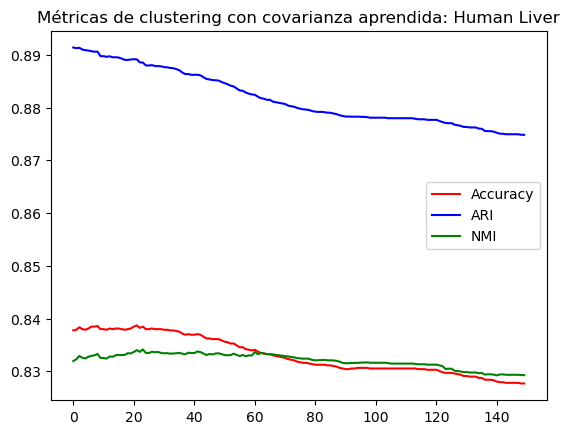

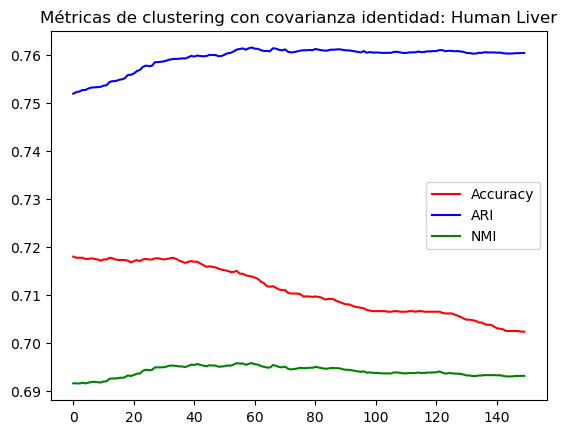

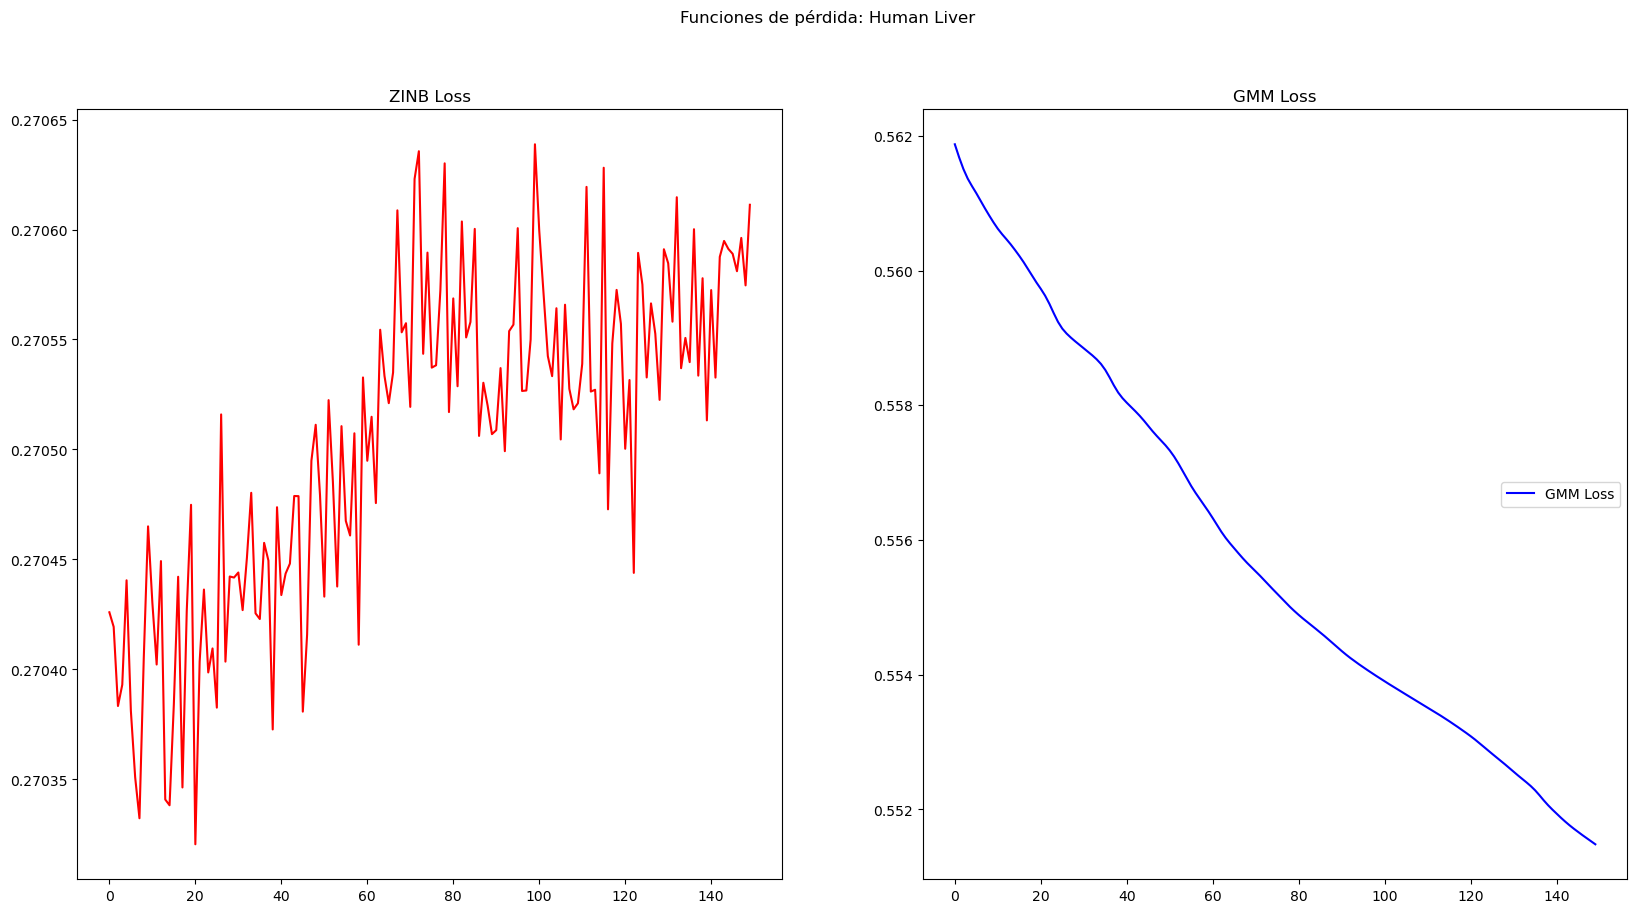

In [22]:
plot_results('results/HumanLiver_14_06/', 'Human Liver')

In [23]:
with open('results/HumanLiver_14_06/prediccion.pickle', 'rb') as f:
    pred = pickle.load(f)

# Lectura de los datos y clusters reales
data_mat = h5py.File('data/Small_Datasets/HumanLiver_counts_top5000.h5')
x = np.array(data_mat['X'])
y = np.array(data_mat['Y'])

print(f'Accuracy: {cluster_acc(y,pred)}')

Accuracy: 0.8276882993841781


## Macosko

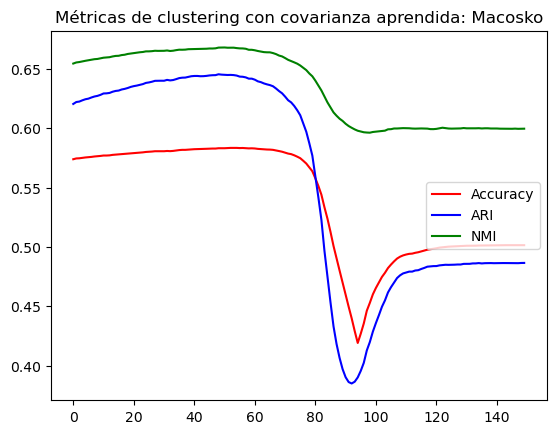

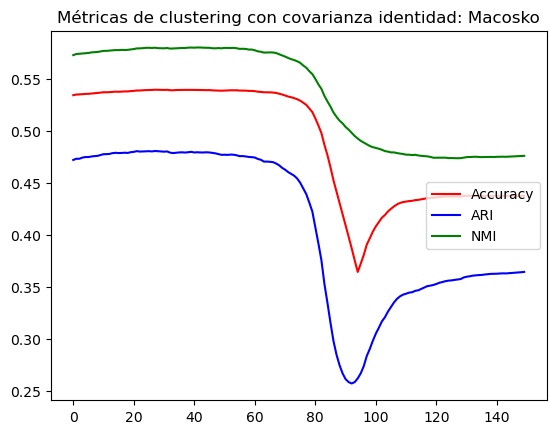

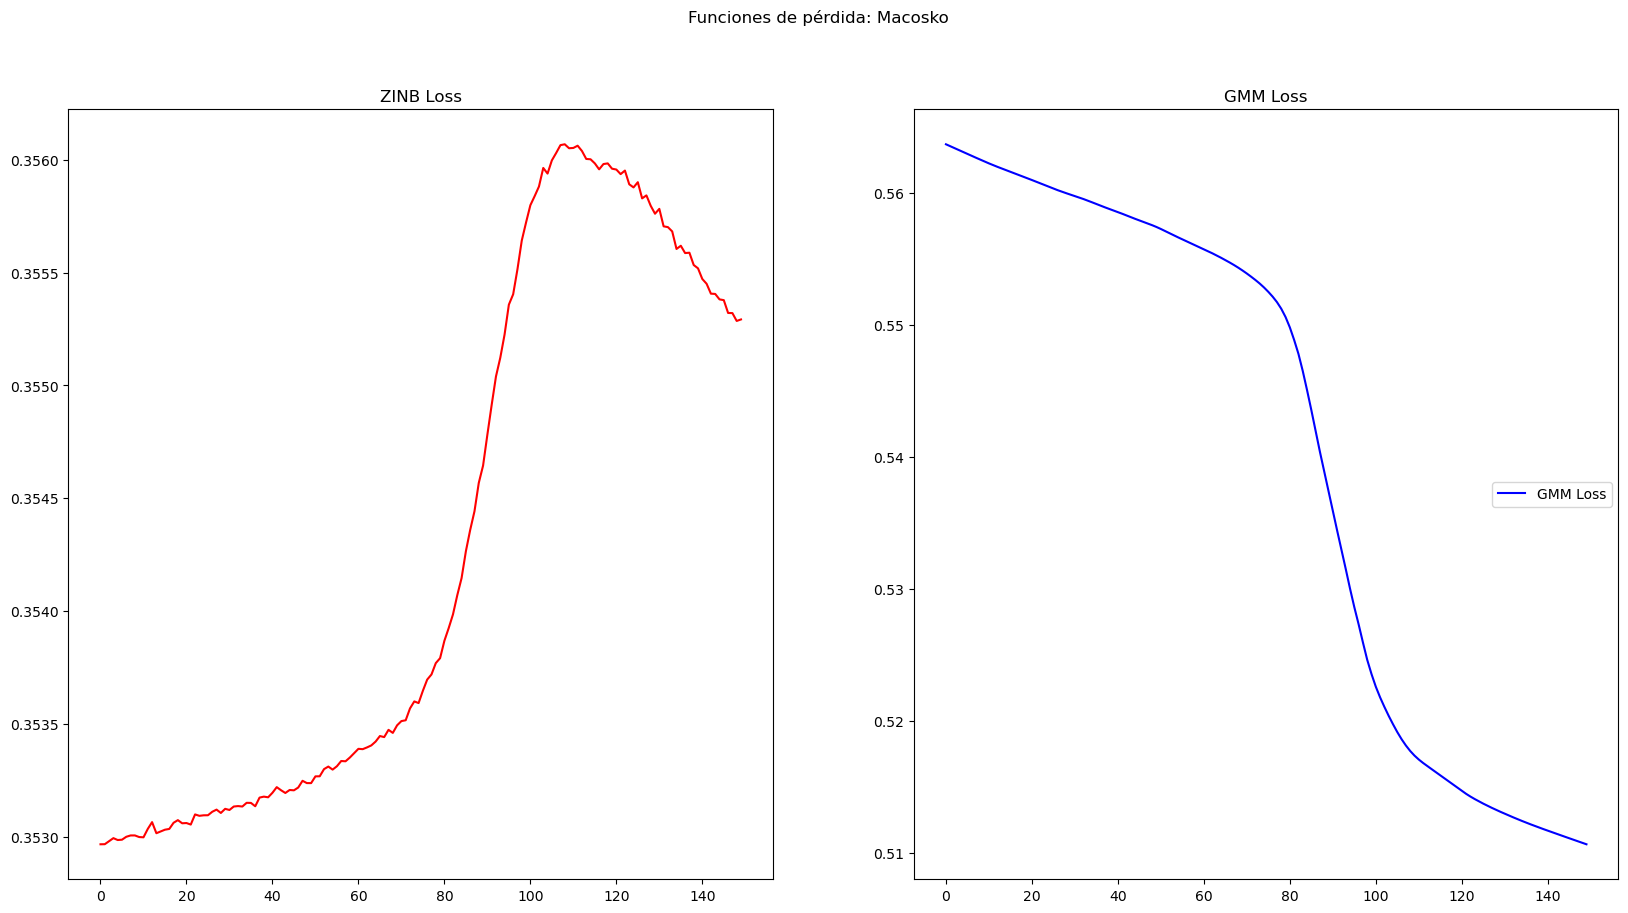

In [10]:
plot_results('results/Macosko_mouse_retina_14_06/', 'Macosko')

In [25]:
with open('results/Macosko_mouse_retina_14_06/prediccion.pickle', 'rb') as f:
    pred = pickle.load(f)

# Lectura de los datos y clusters reales
data_mat = h5py.File('data/Small_Datasets/Macosko_mouse_retina.h5')
x = np.array(data_mat['X'])
y = np.array(data_mat['Y'])

print(f'Accuracy: {cluster_acc(y,pred)}')

Accuracy: 0.5014672763256671
